# Binary 2D classification example using BNN with posterior q=NormalizingFlow

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %pip install -q torch
# %pip install -q normflows

In [3]:
import sys, logging

logging.basicConfig(
        level=logging.INFO,
        stream=sys.stdout,
        format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
        force=True,
    )

In [4]:
import gc

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import time

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    # torch.set_default_tensor_type("torch.cuda.DoubleTensor")
    device = "cuda"

else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"

/home/kusmierc/bnn-from-gp/bnngp/.env/lib/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [6]:
sys.path.append("../")

import reparameterized
from reparameterized import sampling

## Config

In [7]:
random_seed = 1410

In [8]:
net_width = 128

In [9]:
# test grid for plotting
gridlength = 7 
gridwidth = 100

In [10]:
# NF 
nf_model = 0
pretrain_nf = 0 # 0=zeros, 1=zeros for biases and uniform for weights

# NF posterior training
n_epochs = 1000
n_posterior_samples_total = 100
optimizer_lr = 0.001
early_stopping_n_iters = 100

beta = 1.0
beta_annealing = False
beta_annealing_iterations = 200

In [11]:
# HMC posterior training
MCMC_n_samples = 100
MCMC_n_chains = 1

In [12]:
run_id = f"F={nf_model}-{pretrain_nf}_S={n_posterior_samples_total}_E={n_epochs}-{early_stopping_n_iters}_B={beta}-{beta_annealing}-{beta_annealing_iterations}_R={random_seed}"
output_prefix = run_id

## Load and preprocess data.

In [13]:
# !rm *.csv
# !mkdir data/
# !wget https://raw.githubusercontent.com/AaltoML/stationary-activations/main/data/datapoints.csv
# !mv datapoints.csv data/
# !wget https://raw.githubusercontent.com/AaltoML/stationary-activations/main/data/classes.csv
# !mv classes.csv data/

In [14]:
# Download data from .csv files
data = pd.read_csv("data/datapoints.csv", header = None) #2D points
data.columns = [f"col{c}" for c in data.columns]

classes = pd.read_csv("data/classes.csv", header = None) #class labels
classes.columns = [f"col{c}" for c in classes.columns]

N_samples = len(classes) #Number of training samples

# Data to numpy arrays
data_array = np.zeros((N_samples,2))
data_array[:,0] = np.asarray(data.col0[:])
data_array[:,1] = np.asarray(data.col1[:])
class_array = np.asarray(classes.col0)

# Data to torch tensors for training
training_data = torch.from_numpy(data_array).float()
training_targets = torch.from_numpy(class_array).long()

In [15]:

x_vals = np.linspace(-gridlength,gridlength,gridwidth)
y_vals = np.linspace(-gridlength,gridlength,gridwidth)
grid_samples = np.zeros((gridwidth*gridwidth,2))
for i in range(gridwidth):
    for j in range(gridwidth):
        grid_samples[i*gridwidth + j, 0] = x_vals[i]
        grid_samples[i*gridwidth + j, 1] = y_vals[j]

grid_set = torch.from_numpy(grid_samples) #Grid samples to torch tensor

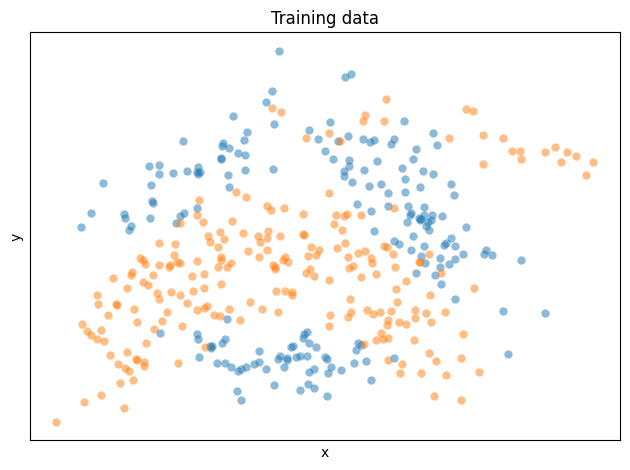

In [16]:
xv, yv = np.meshgrid(x_vals, y_vals) #Sample grid as a meshgrid

fig, ax = plt.subplots()
ax.set_title('Training data')
ax.plot(data_array[class_array==0,0], data_array[class_array==0,1], 'oC0', mew=0, alpha=0.5)
ax.plot(data_array[class_array==1,0], data_array[class_array==1,1], 'oC1', mew=0, alpha=0.5)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

In [17]:
train_x = training_data.to(device)
train_y = training_targets.to(device)

grid_set = grid_set.type(train_x.dtype).to(device)

gc.collect()

20

## Aux

In [18]:
def set_style(ax1):
    ax1.grid(False)
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')


def plot_grid(ax, vals, vmax=1.0, contour=False, cmap='bwr_r'):
    im = ax.imshow(vals, cmap=cmap, #cmap='gray_r',
                   extent=[-gridlength, gridlength, -gridlength, gridlength],
                    origin='lower', alpha=0.5, vmin=0, vmax=vmax)
    ax.scatter(data_array[class_array==0,0], data_array[class_array==0,1], c='red', s=1, alpha=0.35)
    ax.scatter(data_array[class_array==1,0], data_array[class_array==1,1], c='dodgerblue', s=1, alpha=0.5)
    if contour:
        ax.contour(xv, yv, vals, [0.5], colors='k')
    return im


def plot_predictive_bernoulli(p_values, title=None):
    exp_p = p_values.mean(axis=0)  # =E[y] https://en.wikipedia.org/wiki/Law_of_total_expectation
    std_p = p_values.std(axis=0)

    std_exp_y_cond_p = p_values.std(axis=0)
    var_exp_y_cond_p = std_exp_y_cond_p**2  # Var[E[y|p]]

    exp_var_y_cond_p = ( p_values*(1.-p_values) ).mean(axis=0)  # E[Var[y|p]]
    exp_std_y_cond_p = np.sqrt(exp_var_y_cond_p+1e-12)

    var_y = exp_var_y_cond_p + var_exp_y_cond_p  #https://en.wikipedia.org/wiki/Law_of_total_variance
    std_y = np.sqrt(var_y+1e-12)

    exp_p = exp_p.reshape(gridwidth, gridwidth).T
    std_p = std_p.reshape(gridwidth, gridwidth).T
    std_exp_y_cond_p = std_exp_y_cond_p.reshape(gridwidth, gridwidth).T
    exp_std_y_cond_p = exp_std_y_cond_p.reshape(gridwidth, gridwidth).T
    std_y = std_y.reshape(gridwidth, gridwidth).T

    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 8))
    if title:
        plt.suptitle(title)

    file_prefix = (title or "fig")
    file_prefix = file_prefix.lower().replace(" ", "_").replace(":", "-")

    ax = axes[0, 0]
    im = plot_grid(ax, exp_p, vmax=1.0, contour=True, cmap='bwr_r')
    fig.colorbar(im, label="E[y] (=E[p])", ax=ax)
    set_style(ax)
    ax.set_title("Predictive E[y] (=E[p])")

    ax = axes[0, 1]
    im = plot_grid(ax, np.sqrt(exp_p*(1-exp_p)+1e-12), vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, label="Std(E[y])", ax=ax)
    set_style(ax)
    ax.set_title("Predictive Std(E[y])")

    ax = axes[0, 2]
    im = plot_grid(ax, std_p, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="Std[p]")
    set_style(ax)
    ax.set_title("Predictive Std[p]")

    ax = axes[1, 2]
    im = plot_grid(ax, std_exp_y_cond_p, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="Std[E[y|p]]")
    set_style(ax)
    ax.set_title("Predictive Std[E[y|p]]")

    ax = axes[1, 1]
    im = plot_grid(ax, exp_std_y_cond_p, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="E[Std[y|p]]")
    set_style(ax)
    ax.set_title("Predictive E[Std[y|p]]")

    ax = axes[1, 0]
    im = plot_grid(ax, std_y, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="Std[y]")
    set_style(ax)
    ax.set_title("Std[y] (=sqrt( E[Var[y|p]] + Var[E[y|p]]) )")

    fig.tight_layout()

    if output_prefix:
        plot_id = "_T="+(title or "").split("\n")[0].lower().replace(" ", "-")
        plot_id = output_prefix + plot_id
        fig.savefig(plot_id+".pdf")

        df = pd.DataFrame(p_values)
        df.to_csv(plot_id+".csv")    
    
    plt.show()


## BNN

In [19]:
# Activation function
def sigma(x, nu_ind=2, ell=1.0):
    """ See: (https://github.com/AaltoML/stationary-activations)

    Implements the Matern activation function denoted as sigma(x) in Equation 9.
    sigma(x) corresponds to a Matern kernel, with specified smoothness
    parameter nu and length-scale parameter ell.

    Args:
    x: Input to the activation function
    device: A torch.device object
    nu_ind: Index for choosing Matern smoothness (look at nu_list below)
    ell: Matern length-scale, only 0.5 and 1 available with precalculated scaling coefficients
    """
    nu_list = [
        1 / 2,
        3 / 2,
        5 / 2,
        7 / 2,
        9 / 2,
    ]  # list of available smoothness parameters
    nu = torch.tensor(nu_list[nu_ind])  # smoothness parameter
    lamb = torch.sqrt(2 * nu) / ell  # lambda parameter
    v = nu + 1 / 2
    # Precalculated scaling coefficients for two different lengthscales (q divided by Gammafunction at nu + 0.5)
    ell05A = [
        4.0,
        19.595917942265423,
        65.31972647421809,
        176.69358285524189,
        413.0710073859664,
    ]
    ell1A = [
        2.0,
        4.898979485566356,
        8.16496580927726,
        11.043348928452618,
        12.90846898081145,
    ]
    if ell == 0.5:
        A = ell05A[nu_ind]
    if ell == 1:
        A = ell1A[nu_ind]
    y = A * torch.sign(x) * torch.abs(x) ** (v - 1) * torch.exp(-lamb * torch.abs(x))
    y[x < 0] = 0  # Values at x<0 must all be 0
    return y


In [20]:
activation = sigma

def get_predictive(logit):
    return torch.sigmoid(logit)


In [21]:
prior_params = {
    "layer1.weight.loc": 0,
    "layer1.bias.loc": 0,
    "layer1.weight.scale": 0.37772881984710693,
    "layer1.bias.scale": 0.48267459869384766,
    "layer2.weight.loc": 0,
    "layer2.bias.loc": 0,
    "layer2.weight.scale": 0.8050532937049866,
    "layer2.bias.scale": 0.24227333068847656,
}

### Network

In [22]:
def decode_torch_gaussian_priors(prior_params, net_width):
    c = prior_params
    return {
        'fc1.weight': torch.distributions.MultivariateNormal(loc=torch.zeros(torch.Size([2*net_width]))+c["layer1.weight.loc"], covariance_matrix=torch.diag(torch.ones(2*net_width)*c["layer1.weight.scale"]**2)),
        'fc1.bias': torch.distributions.MultivariateNormal(loc=torch.zeros(torch.Size([net_width]))+c["layer1.bias.loc"], covariance_matrix=torch.diag(torch.ones(net_width)*c["layer1.bias.scale"]**2)),
        'fc2.weight': torch.distributions.MultivariateNormal(loc=torch.zeros(torch.Size([net_width]))+c["layer2.weight.loc"], covariance_matrix=torch.diag(torch.ones(net_width)*c["layer2.weight.scale"]**2)),
        'fc2.bias': torch.distributions.MultivariateNormal(loc=torch.zeros(1)+c["layer2.bias.loc"],  covariance_matrix=torch.diag(torch.ones(1)*c["layer2.bias.scale"]**2)),
    }
    

priors = decode_torch_gaussian_priors(prior_params, net_width)    


def log_priors(priors, samples):
    return sum(priors[n].log_prob(p.flatten()) for n, p in samples.items())  # sum over all parameters

In [23]:
# Network
class SingleHiddenLayerWideNN(torch.nn.Module):
    def __init__(self, width=1000, indim=1, outdim=1, activation=None):
        super().__init__()
        self.width = width
        self.fc1 = torch.nn.Linear(indim, width)
        self.fc2 = torch.nn.Linear(width, outdim)
        self.activation = activation

    def forward(self, x, learnable_activation=None):
        learnable_activation = self.activation or learnable_activation

        x = self.fc1(x)
        x = learnable_activation(x)
        x = self.fc2(x)
        return x

In [24]:
bnn = SingleHiddenLayerWideNN(indim=2, width=net_width, activation=activation)
print(bnn)

SingleHiddenLayerWideNN(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [25]:
def log_likelihood(bnn, train_x, train_y, eps=1e-6):
    p = get_predictive(bnn(train_x)).flatten()
    return train_y*torch.log(p+eps) + (1.-train_y)*torch.log(1.-p+eps)

In [26]:
def plot_predicitive(bnn, sampler, n_samples=100, n_samples_per_sampling=10, **kwargs):
    assert n_samples%n_samples_per_sampling==0, "n_samples_per_sampling must divide n_samples"
    x = grid_set
    
    with torch.no_grad():
        p_values = []
        for _ in tqdm(range(n_samples//n_samples_per_sampling)):
            samples, _ = sampler(n_samples_per_sampling)
    
            for s in reparameterized.take_parameters_sample(samples):
                reparameterized.load_state_dict(bnn, s)
                p = get_predictive(bnn(x))
                p_values.append(p.cpu().detach().numpy())
    
                gc.collect()
        p_values = np.stack(p_values)[:,:,0]
        assert p_values.shape == torch.Size([n_samples, x.shape[0]]), f"p_values.shape={p_values.shape} vs {n_samples, x.shape[0]}"

    plot_predictive_bernoulli(p_values, **kwargs)
    gc.collect()

### Posterior Sampler = Normalizing Flow

In [27]:
torch.manual_seed(random_seed)

In [28]:
# Initalize flows (pretrain flows to match desired inital distributions)
if pretrain_nf is None:
    pretrain_flow_target = None

elif pretrain_nf==1:
    parameters_shapes = sampling.multiparameter.extract_parameters_shapes(bnn.named_parameters())
    pretrain_flow_target = sampling.normflows_common.WeightsAndBiasesSampler(parameters_shapes, 
                                                                             weight_init='xavier_uniform', bias_init='zeros'
                                                                            )
elif pretrain_nf==0:
    n_parameters = sampling.multiparameter.get_parameters_total_n_elements(bnn.named_parameters())
    pretrain_flow_target = sampling.normflows_common.ZerosSampler(n_parameters)

else:
    raise ValueError(f"Wrong value of pretrain_nf={pretrain_nf}!")

In [29]:
if nf_model==0:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        dict(bnn.named_parameters()),
        build_flow_func = sampling.realnvp.build_realnvp,
        realnvp_rezero=False,
        realnvp_num_layers=32,
        realnvp_m=6*net_width,
        )
    n_posterior_samples = n_posterior_samples_total  # in one forward operation

elif nf_model==1:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        dict(bnn.named_parameters()),
        build_flow_func = sampling.normflows_realnvp.build_realnvp_flow,
        realnvp_flow_K=8,
        realnvp_init_zeros=True,
        realnvp_trainable_prior=False,
        pretrain_flow_target=pretrain_flow_target,
        )
    n_posterior_samples = n_posterior_samples_total  # in one forward operation

elif nf_model==2:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        dict(bnn.named_parameters()),
        build_flow_func = sampling.normflows_residual.build_residual_flow,
        residual_flow_K=12,
        residual_hidden_units=32,
        residual_hidden_layers=3,
        residual_trainable_prior=False,    
        pretrain_flow_target=pretrain_flow_target,
        )
    n_posterior_samples = 20

elif nf_model==3:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        dict(bnn.named_parameters()),
        build_flow_func = sampling.normflows_neural_spline.build_spline_flow,
        spline_flow_K=4,
        spline_flow_hidden_units=16,
        spline_flow_hidden_layers=2,
        pretrain_flow_target=pretrain_flow_target,
        )
    logging.warning("Reducing n_posterior_samples_total down to 10 for spline flow!")
    n_posterior_samples_total = 10
    n_posterior_samples = n_posterior_samples_total  # in one forward operation
    
else:
    raise ValueError(f"Wrong value of nf_model={nf_model}!")

In [30]:
start_time = time.time()
samples, q_nlls = sampler(1)
print(f"sampled 1 sample in {time.time()-start_time: .2f}s")

s1 = next(reparameterized.take_parameters_sample(samples))
n_parameters = sum(s.numel() for s in s1.values())
print(f"n_parameters = {n_parameters}")

n_variational_params = sum(p.numel() for p in variational_params.values())
print(f"n_variational_params = {n_variational_params}")

sampled 1 sample in  0.14s
n_parameters = 513
n_variational_params = 63078400


In [43]:
print("samples=", samples, "q_nlls=", q_nlls)

In [32]:
print(f"Using device samples={next(iter(samples.values())).device} train_x={train_x.device}")

Using device samples=cuda:0 train_x=cuda:0


In [33]:
# start_time = time.time()
# n_samples = 20
# samples, q_nlls = sampler(n_samples)
# print(f"sampled {n_samples} samples in {time.time()-start_time: .2f}s")

### Training

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


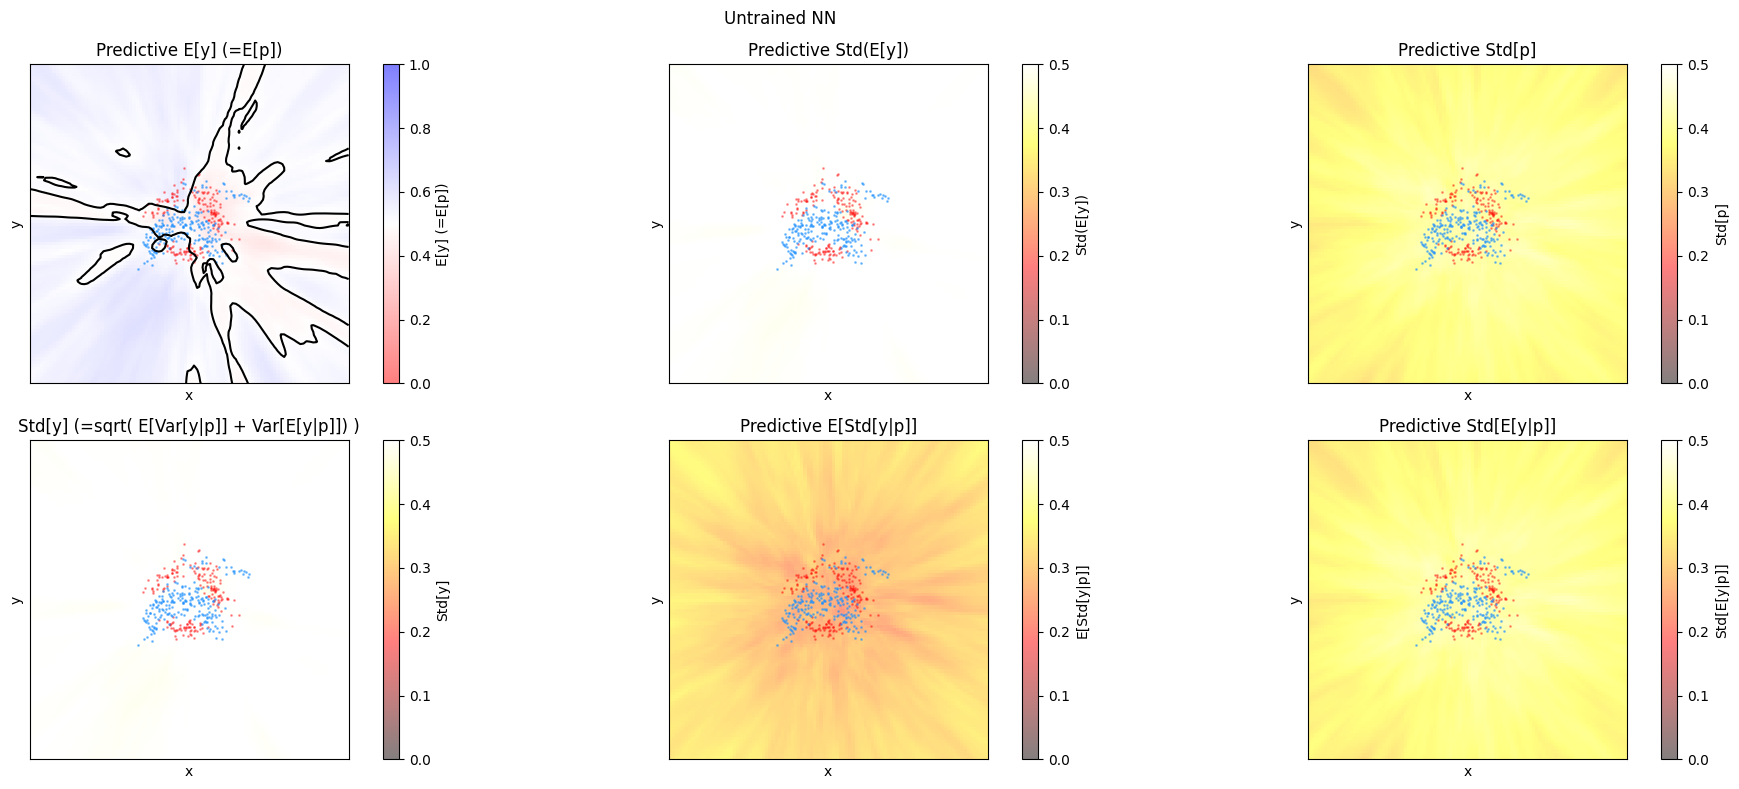

In [34]:
plot_predicitive(bnn, sampler, title="Untrained NN")

  0%|          | 1/200 [00:00<01:58,  1.68it/s]

[ 1s] epoch=0: loss= 2620.10 log_lik=-944.50 KLD= 1675.60


  6%|▌         | 11/200 [00:05<01:26,  2.20it/s]

[ 5s] epoch=10: loss= 1103.74 log_lik=-253.71 KLD= 850.03


 10%|█         | 21/200 [00:09<01:21,  2.20it/s]

[ 10s] epoch=20: loss= 586.96 log_lik=-275.34 KLD= 311.62


 16%|█▌        | 31/200 [00:14<01:16,  2.20it/s]

[ 14s] epoch=30: loss= 425.54 log_lik=-254.43 KLD= 171.11


 20%|██        | 41/200 [00:18<01:12,  2.19it/s]

[ 19s] epoch=40: loss= 400.20 log_lik=-242.74 KLD= 157.47


 26%|██▌       | 51/200 [00:23<01:07,  2.22it/s]

[ 23s] epoch=50: loss= 378.24 log_lik=-230.72 KLD= 147.53


 30%|███       | 61/200 [00:27<01:02,  2.21it/s]

[ 28s] epoch=60: loss= 363.53 log_lik=-223.48 KLD= 140.06


 36%|███▌      | 71/200 [00:32<00:57,  2.23it/s]

[ 32s] epoch=70: loss= 354.88 log_lik=-205.67 KLD= 149.21


 40%|████      | 81/200 [00:36<00:53,  2.23it/s]

[ 37s] epoch=80: loss= 353.72 log_lik=-206.46 KLD= 147.26


 46%|████▌     | 91/200 [00:41<00:49,  2.22it/s]

[ 41s] epoch=90: loss= 344.19 log_lik=-202.88 KLD= 141.31


 50%|█████     | 100/200 [00:45<00:44,  2.23it/s]

[ 46s] epoch=100: loss= 344.46 log_lik=-198.06 KLD= 146.40



100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


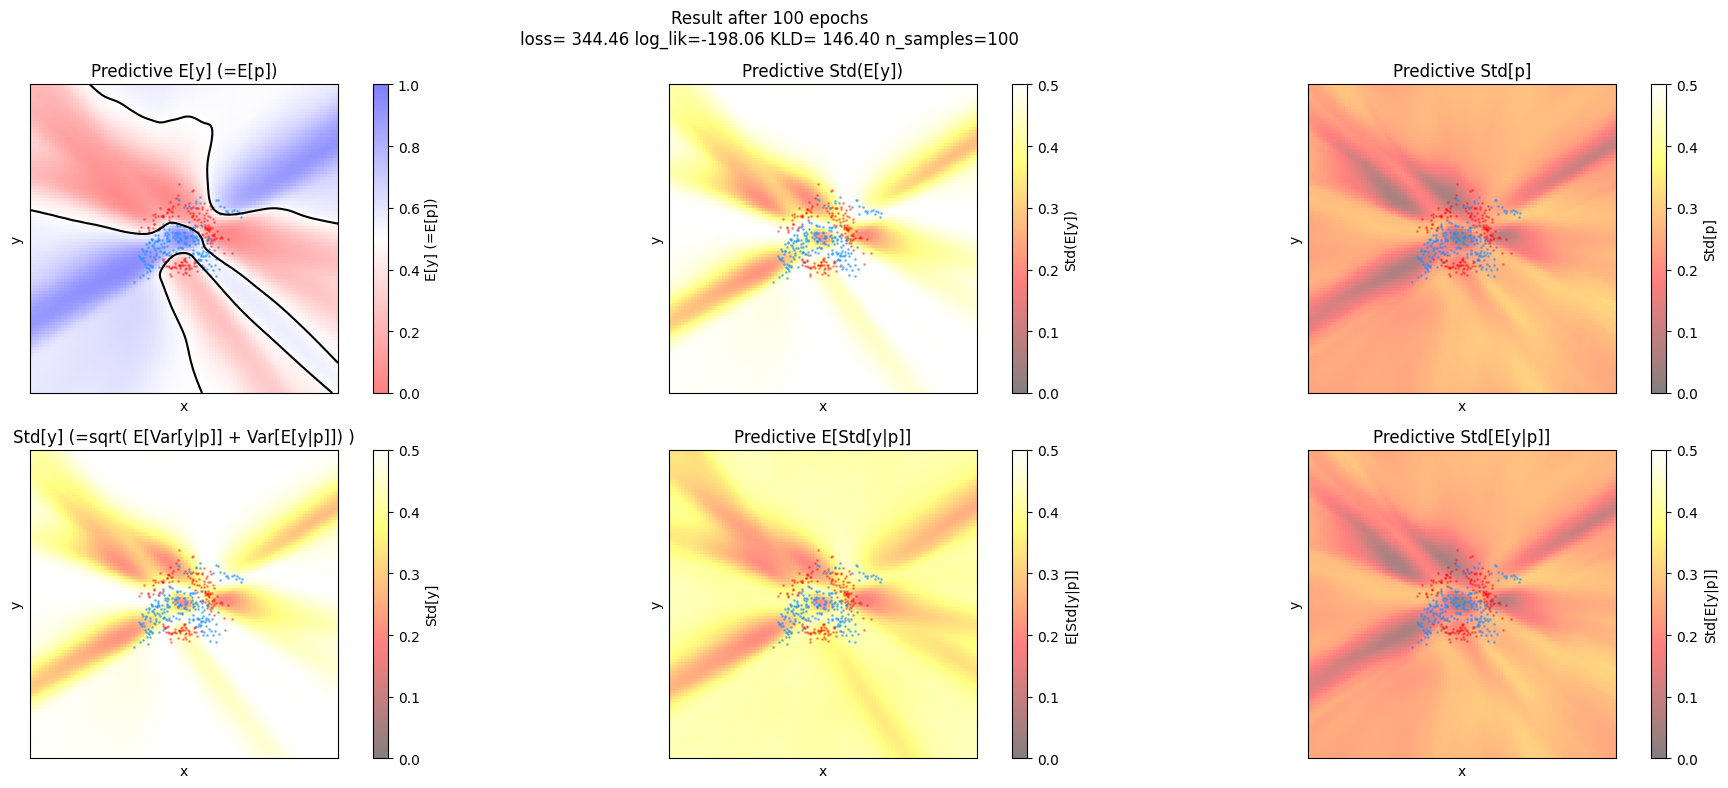

100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


In [35]:
optimized_parameters = variational_params.values()
optimizer = torch.optim.Adam(optimized_parameters, lr=optimizer_lr)

assert n_posterior_samples_total % n_posterior_samples == 0, "n_posterior_samples must divide n_posterior_samples_total"

start_time = time.time()
best_loss, best_it = float("inf"), -early_stopping_n_iters  # early stopping initialization
beta_max = beta
for it in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    if beta_annealing:
        beta = np.min([beta_max, 0.001 + it / beta_annealing_iterations])

    loss_vi = 0.
    KLDs = []
    log_liks = []
    for _ in range(n_posterior_samples_total//n_posterior_samples):  # gradient accumulation steps
        samples, q_nlls = sampler(n_samples=n_posterior_samples)
        assert not q_nlls.isnan().any(), q_nlls

        p_nlls = [-log_priors(priors, s) for s in reparameterized.take_parameters_sample(samples)]
        p_nlls = torch.stack(p_nlls)

        assert p_nlls.shape == q_nlls.shape
        KLD = p_nlls-q_nlls
        KLD = KLD.sum()/n_posterior_samples  # average over n_posterior_samples
        KLDs.append(KLD.detach().cpu().item())

        log_lik = 0.
        for s in reparameterized.take_parameters_sample(samples):
            reparameterized.load_state_dict(bnn, s)
            ll = log_likelihood(bnn, train_x, train_y)
            log_lik += ll.sum()
        log_lik /= n_posterior_samples # average over n_posterior_samples
        log_liks.append(log_lik.detach().cpu().item())

        loss_vi += - (log_lik - beta*KLD)
        gc.collect()
        
    loss_vi.backward()
    optimizer.step()        

    # early stopping    
    if not beta_annealing or it > beta_annealing_iterations:
        loss = loss_vi.item()
        if loss < best_loss:
            best_loss, best_it = loss, it

        if it > best_it + early_stopping_n_iters:
            logging.info(
                f"[train_nfm] Early stopping due to no improvement in {early_stopping_n_iters} iterations. " 
                f"best_loss={best_loss}, current loss={loss}."
            )
            break

    # reporting
    if (it<100 and it%10==0) or it%100==0:        
        log_lik = np.mean(log_liks)
        KLD = np.mean(KLDs)
        res_str = f"loss={loss_vi: .2f} log_lik={log_lik: .2f} KLD={KLD: .2f}"
        print(f"[{time.time()-start_time: .0f}s] epoch={it}: {res_str}")
        
        if it in [100, 500, beta_annealing_iterations] or (it>=1000 and it%1000==0):
            plot_predicitive(bnn, sampler, 
                             title=f"Result after {it} epochs\n{res_str} n_samples={n_posterior_samples_total}", 
                             n_samples=40)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


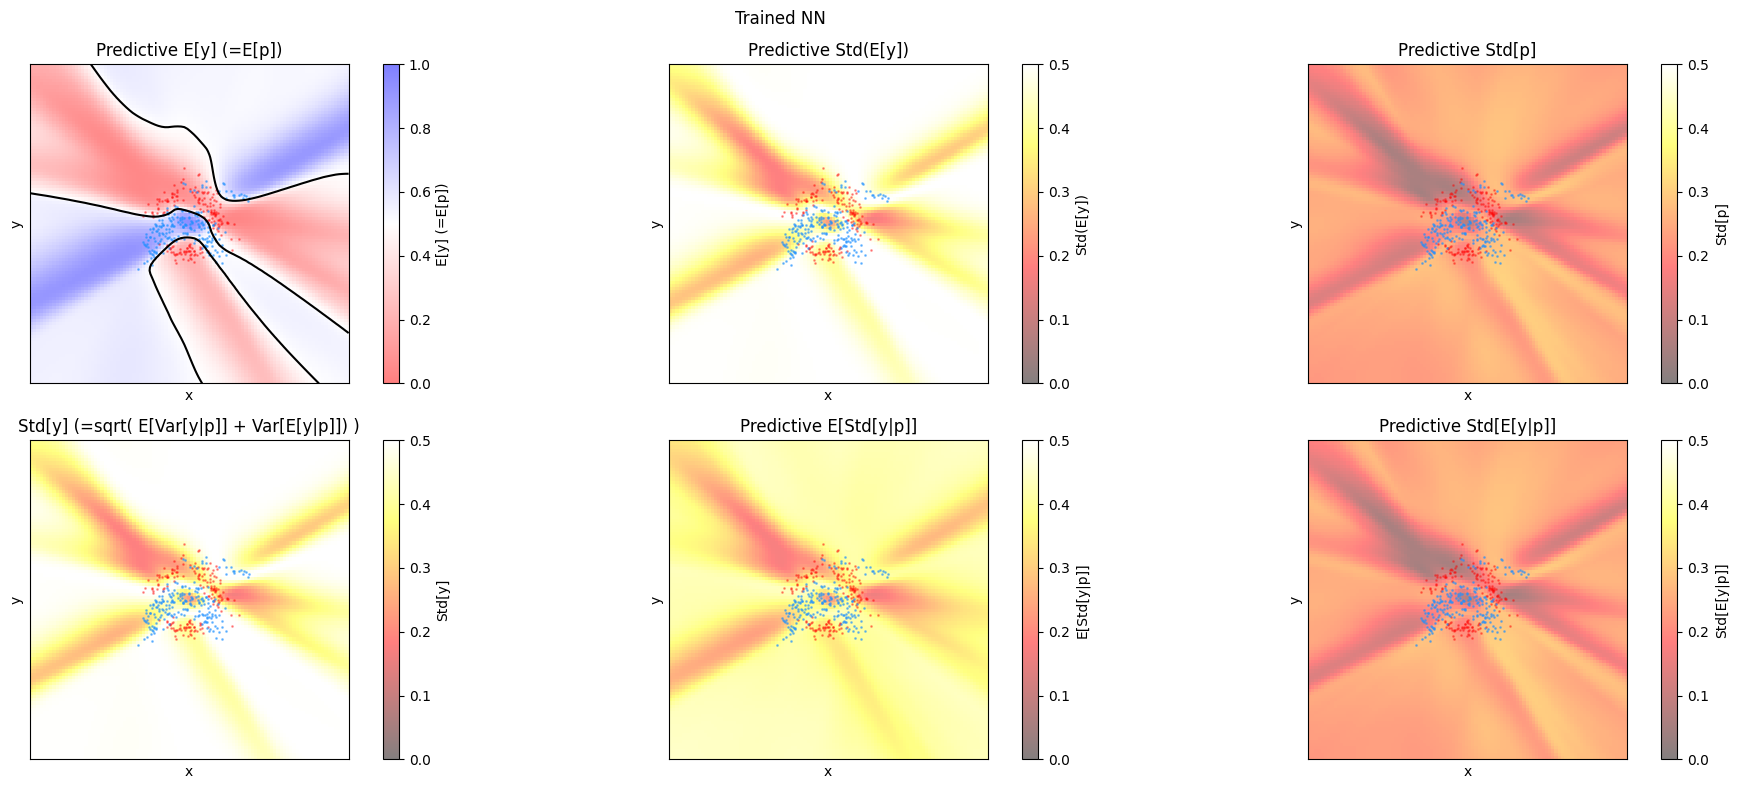

In [36]:
plot_predicitive(bnn, sampler, title="Trained NN")

## MCMC Baseline

In [37]:
from torch import nn

import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive


In [38]:
def decode_pyro_gaussian_priors(prior_params):
    return {
        "layer1.weight": dist.Normal(
            prior_params["layer1.weight.loc"], prior_params["layer1.weight.scale"]
        ),
        "layer1.bias": dist.Normal(prior_params["layer1.bias.loc"], prior_params["layer1.bias.scale"]),
        "layer2.weight": dist.Normal(prior_params["layer2.weight.loc"], prior_params["layer2.weight.scale"]),
        "layer2.bias": dist.Normal(prior_params["layer2.bias.loc"], prior_params["layer2.bias.scale"]),
    }

In [39]:
# BNN: Single-hidden-layer NN
class SingleHiddenLayerWideNNPyro(PyroModule):
    def __init__(
        self,
        activation,
        prior_params,
        net_width=1000,
        in_dim=2,
        out_dim=1,
    ):
        super().__init__()
        self.in_dim = in_dim

        # Activation:
        self.activation = activation 
        if hasattr(
            self.activation, "named_parameters"
        ):  # turn off gradients in the module
            [p.requires_grad_(False) for _, p in self.activation.named_parameters()]

        # Model:
        self.layer1 = PyroModule[nn.Linear](in_dim, net_width)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](
            net_width, out_dim
        )  # Hidden to output layer

        # Set layer parameters as random variables
        priors = decode_pyro_gaussian_priors(prior_params)        
        self.layer1.weight = PyroSample(
            priors["layer1.weight"].expand([net_width, in_dim]).to_event(2)
        )
        self.layer1.bias = PyroSample(
            priors["layer1.bias"].expand([net_width]).to_event(1)
        )
        self.layer2.weight = PyroSample(
            priors["layer2.weight"].expand([out_dim, net_width]).to_event(2)
        )
        self.layer2.bias = PyroSample(
            priors["layer2.bias"].expand([out_dim]).to_event(1)
        )

    def forward(self, x, y=None):
        x = x.reshape(-1, self.in_dim)
        x = self.layer1(x)
        with torch.no_grad():
            x = self.activation(x)
        mu = self.layer2(x).squeeze()

        # Likelihood model
        p = get_predictive(mu)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(probs=p), obs=y)
            # obs = pyro.sample("obs", dist.RelaxedBernoulliStraightThrough(probs=p, temperature=torch.tensor(0.1)), obs=y)

        # Register p as a deterministic output
        pyro.deterministic("p", p)

        if y is not None:
            log_likelihood = dist.Bernoulli(probs=p).log_prob(y)
            pyro.deterministic("log_likelihood", log_likelihood)

        return p

In [40]:
bnn_pyro = SingleHiddenLayerWideNNPyro(activation=activation, prior_params=prior_params, net_width=net_width)

In [41]:
# Define Hamiltonian Monte Carlo (HMC) kernel

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(bnn_pyro, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get MC posterior samples
mcmc = MCMC(nuts_kernel, num_samples=MCMC_n_samples//MCMC_n_chains, num_chains=MCMC_n_chains) #, disable_validation=True)

# Run MCMC
mcmc.run(train_x, torch.tensor(train_y, dtype=torch.float))

# Print summary statistics
mcmc.summary(prob=0.8)  # This gives you the 80% credible interval by default

predictive = Predictive(model=bnn_pyro, posterior_samples=mcmc.get_samples())
preds = predictive(train_x, train_y.type(torch.float32))

/tmp/ipykernel_1880975/2666265246.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mcmc.run(train_x, torch.tensor(train_y, dtype=torch.float))
Warmup:   0%|          | 0/200 [00:00, ?it/s]/tmp/ipykernel_1880975/1063437157.py:22: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu = torch.tensor(nu_list[nu_ind])  # smoothness parameter
/home/kusmierc/bnn-from-gp/bnngp/.env/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to crea


                          mean       std    median     10.0%     90.0%     n_eff     r_hat
      layer1.bias[0]      0.05      0.58      0.02     -0.51      0.66    126.35      0.99
      layer1.bias[1]     -0.02      0.42     -0.02     -0.65      0.51    124.96      0.99
      layer1.bias[2]     -0.03      0.60     -0.04     -0.66      0.70     79.21      1.00
      layer1.bias[3]      0.00      0.46      0.01     -0.71      0.42     88.41      0.99
      layer1.bias[4]      0.03      0.52      0.02     -0.65      0.51    116.59      0.99
      layer1.bias[5]     -0.00      0.40     -0.02     -0.54      0.44     79.04      0.99
      layer1.bias[6]     -0.09      0.46     -0.13     -0.79      0.32    137.47      1.03
      layer1.bias[7]      0.04      0.51      0.03     -0.45      0.74     73.74      0.99
      layer1.bias[8]      0.07      0.42      0.06     -0.42      0.52    138.30      0.99
      layer1.bias[9]      0.10      0.53      0.13     -0.40      0.94     48.79      1.0

BNN preds: grid_set.shape=torch.Size([10000, 2]) p.shape=torch.Size([100, 1, 10000]) obs=torch.Size([100, 10000])


/tmp/ipykernel_1880975/2466110138.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_std_y_cond_p = np.sqrt(exp_var_y_cond_p+1e-12)
/tmp/ipykernel_1880975/2466110138.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std_y = np.sqrt(var_y+1e-12)
/tmp/ipykernel_1880975/2466110138.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  im = plot_grid(ax, np.sqrt(exp_p*(1-exp_p)+1e-12), vmax=0.5, contour=False, cmap='hot')


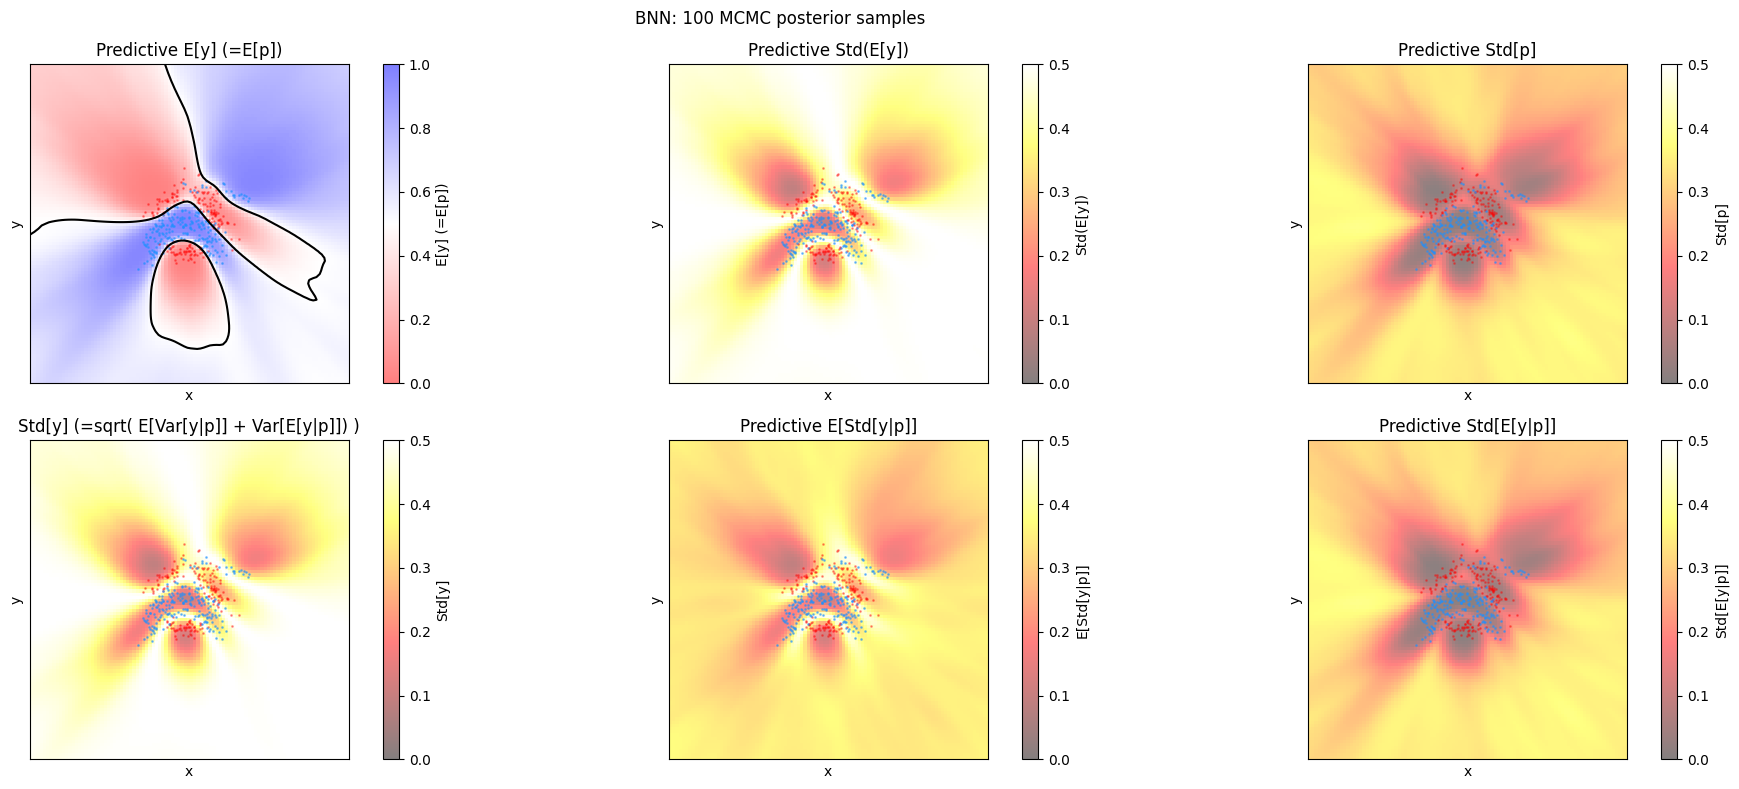

In [42]:
# p_values = torch.stack([bnn_model(grid_set) for _ in range(MC)])
preds = predictive(grid_set)
print(f"BNN preds: grid_set.shape={grid_set.shape} p.shape={preds['p'].shape} obs={preds['obs'].shape}")
bnn_p_samples_for_eval = p_samples = preds['p'][:,0,:].detach().cpu()  # Get Bernoulli p values

MC = preds['p'].shape[0]
plot_predictive_bernoulli(p_samples, title=f"BNN: {MC} MCMC posterior samples"); plt.show()